In [1]:
import pendulum

import geopandas as gpd
from google.cloud import storage
import gcsfs

import seaborn as sns
import os

import numpy as np
import pandas as pd
import osmnx

from scipy import stats

import fiona
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
import statsmodels.formula.api as smf
import statsmodels.api as sm
import networkx as nx
import osmnx as ox
import os 
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
import shapely.geometry as geom
import shapely.wkt

C:\Users\mmmiah\AppData\Local\ESRI\conda\envs\geo_env\Lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_18396\3145899087.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (http

In [2]:
#!pip install statsmodels

In [3]:
#!pip install pendulum
# !pip install google-cloud
# !pip install google-cloud-vision
#!pip install --upgrade google-cloud-storage
#!pip install gcsfs

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import os, time, math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score, cross_validate

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [5]:
# Helper Function
def rmse(predictions, targets, **kwargs):
    return np.sqrt(mean_squared_error(targets, predictions))


def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
# src: https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn


def mean_absolute_percentage_error(y_true, y_pred, **kwargs):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Create a custom scorer based on MAPE. This is used in GridSearchCV. Also
# used in sklearn, since that package does not offer MAPE as a scorer.
MAPE_SCORER = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
MAE_SCORER = make_scorer(mean_absolute_error, greater_is_better=False)
RMSE_SCORER = make_scorer(rmse, greater_is_better=False)
MSE_SCORER = make_scorer(mean_squared_error, greater_is_better=False)
R2_SCORER = make_scorer(r2_score, greater_is_better=True)

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

# Helper Function
def min_distance_ppoly(point, polygon):
    return polygon.distance(point).min()

In [6]:
# read the indices
ind=pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Processed Data/Updated_indices.csv')
ind.head()

,Unnamed: 0.1,ID,year,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,...,state,country,Unnamed: 0,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio
0,0,671,2016,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,0.930693,...,California,United States,0,308723101,215845474,NaN,NaN,NaN,NaN,NaN
1,1,671,2017,2.893617,0.776723,0.743791,0.376689,1.974549,0.437975,1.020619,...,California,United States,0,308723101,215845474,NaN,NaN,NaN,NaN,NaN
2,2,671,2018,1.352564,0.710009,0.863646,0.291176,2.966061,0.295405,1.433566,...,California,United States,0,308723101,215845474,4890.0,260.0,4630.0,0.053170,0.946830
3,3,671,2019,1.435644,0.660785,0.820369,0.340759,2.407476,0.354620,1.210702,...,California,United States,0,308723101,215845474,4625.0,255.0,4370.0,0.055135,0.944865
4,4,1127,2016,2.222222,0.257277,2.050485,0.584499,3.508108,0.736655,2.235149,...,California,United States,1,308779961,87297166,NaN,NaN,NaN,NaN,NaN


In [7]:
## Try to pull whole CA state Network using polygon
ca_poly=gpd.read_file('H:/Desktop/AT Census/OSM Bike Network/ca-state-boundary/CA_State_TIGER2016.shp',encoding='utf-8')
ca_poly2=gpd.GeoDataFrame(ca_poly, geometry='geometry', crs='EPSG:3857')
one_mile=1609.34
ca_poly2['geometry'] = ca_poly2['geometry'].buffer(one_mile)
ca_poly3=ca_poly2.to_crs("epsg:4326")
ca_poly3

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,"MULTIPOLYGON (((-124.44237 40.35934, -124.4430..."


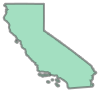

In [8]:
polygon=ca_poly3.loc[0,'geometry']
polygon

In [9]:
count_sites=ind

In [10]:
# Use Dr. Frank Code to get population density for each location of the counter within buffer
count_sites['geometry'] = gpd.points_from_xy(count_sites.longitude, count_sites.latitude)

count_sites = gpd.GeoDataFrame(count_sites, geometry='geometry', crs='EPSG:4326')

In [11]:
# project the data for geographic analysis
count_sites = count_sites.to_crs(3310)

In [12]:
# Calculate the CBD distance
#https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dtownhall
# Import University
tags = {'office': 'government'}
city_hall = ox.geometries_from_polygon(polygon, tags)
city_proj = city_hall.to_crs(epsg=3310)

In [13]:
# Consider the rows that have city hall
city_proj1 = city_proj[city_proj['name'].str.contains('City Hall', regex=False, case=False, na=False)]
city_proj2 = city_proj[city_proj['name'].str.contains('Town Hall', regex=False, case=False, na=False)]
city_proj3 = city_proj[city_proj['name'].str.contains('Civic Center', regex=False, case=False, na=False)]
city_proj4 = city_proj[city_proj['name'].str.contains('Administration Building', regex=False, case=False, na=False)]
city_proj5=pd.concat([city_proj1,city_proj2,city_proj3,city_proj4]).reset_index()
city_proj5.head(2)

,element_type,osmid,geometry,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,name,office,...,tourism,suite,name_1,name_2,name_3,building:min_level,police,historic:name,building:use,image
0,way,112118983,"POLYGON ((256114.438 -487436.361, 256128.718 -...",Wildomar,NaN,23873,92595,Clinton Keith Road,Wildomar City Hall,government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way,121955310,"POLYGON ((265173.826 -498221.861, 265180.761 -...",NaN,NaN,NaN,NaN,NaN,City Hall,government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Distance to CBD
count_sites['CBD_Distance'] = count_sites.geometry.apply(min_distance_ppoly, args=(city_proj5,))*0.000621371
count_sites=count_sites.reset_index()
count_sites.head(2)

,index,Unnamed: 0.1,ID,year,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,...,Unnamed: 0,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD_Distance
0,0,0,671,2016,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,...,0,308723101,215845474,NaN,NaN,NaN,NaN,NaN,POINT (-216265.861 -22230.259),5.149648
1,1,1,671,2017,2.893617,0.776723,0.743791,0.376689,1.974549,0.437975,...,0,308723101,215845474,NaN,NaN,NaN,NaN,NaN,POINT (-216265.861 -22230.259),5.149648


In [15]:
count_sites['CBD_Distance'].describe()

count    595.000000
mean      13.581384
std       20.072239
min        0.124926
25%        4.229752
50%        6.194739
75%       14.599145
max      169.346059
Name: CBD_Distance, dtype: float64

In [16]:
#read Block group
block_groups_CA = gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Block_Gp/nhgis0101_shape/nhgis0101_shape/nhgis0101_shapefile_tl2019_060_blck_grp_2019/CA_blck_grp_2019.shp')
block_groups_Ne=  gpd.read_file('H:/Desktop/Bike_ped Exposure Model Project/Block_Gp/nhgis0101_shape/nhgis0101_shape/nhgis0101_shapefile_tl2019_320_blck_grp_2019/NV_blck_grp_2019.shp')
block_groups=pd.concat([block_groups_CA,block_groups_Ne],axis=0).set_index('GEOID')
block_groups['aland_sqmi'] = block_groups['ALAND'] / (1609.*1609.)
block_groups.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,aland_sqmi
GEOID,,,,,,,,,,,,,,,,
060014001001,G06000104001001,06,001,400100,1,Block Group 1,G5030,S,6894339.0,0.0,+37.8676275,-122.2319460,14302.721555,6.894335e+06,"POLYGON ((-2255602.272 353149.335, -2255597.39...",2.663058
060014002001,G06000104002001,06,001,400200,1,Block Group 1,G5030,S,288069.0,0.0,+37.8497451,-122.2488478,2971.010308,2.880696e+05,"POLYGON ((-2258184.246 353217.527, -2258186.81...",0.111272
060014002002,G06000104002002,06,001,400200,2,Block Group 2,G5030,S,298490.0,0.0,+37.8465865,-122.2503095,3162.343955,2.984887e+05,"POLYGON ((-2258439.130 352894.146, -2258619.65...",0.115297
060014003001,G06000104003001,06,001,400300,1,Block Group 1,G5030,S,265695.0,0.0,+37.8439848,-122.2486668,2553.074982,2.656948e+05,"POLYGON ((-2258662.984 352641.307, -2258755.16...",0.102629
060014003002,G06000104003002,06,001,400300,2,Block Group 2,G5030,S,269347.0,0.0,+37.8362550,-122.2516875,3534.834596,2.693459e+05,"POLYGON ((-2259955.644 352133.337, -2259945.80...",0.104040


In [17]:
block_groups.columns

Index(['GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'Shape_Leng', 'Shape_Area', 'geometry', 'aland_sqmi'],
      dtype='object')

In [18]:
block_groups.crs

<Derived Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [19]:
bg_pop = pd.read_csv('H:/Desktop/Bike_ped Exposure Model Project/Block_Gp/pop/nhgis0102_csv/nhgis0102_ds244_20195_blck_grp.csv')
bg_pop['geoid'] = bg_pop['GEOID'].str[7:]
bg_pop = bg_pop.set_index('geoid')
bg_pop = bg_pop.rename(columns={'ALUBE001': 'pop'})
bg_pop.head()

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,SDUNIA,PCI,PUMAA,GEOID,BTTRA,BTBGA,NAME_E,pop,NAME_M,ALUBM001
geoid,,,,,,,,,,,,,,,,,,,,,
060014001001,G06000104001001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014001001,NaN,NaN,"Block Group 1, Census Tract 4001, Alameda Coun...",3120,"Block Group 1, Census Tract 4001, Alameda Coun...",208
060014002001,G06000104002001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014002001,NaN,NaN,"Block Group 1, Census Tract 4002, Alameda Coun...",990,"Block Group 1, Census Tract 4002, Alameda Coun...",138
060014002002,G06000104002002,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014002002,NaN,NaN,"Block Group 2, Census Tract 4002, Alameda Coun...",1017,"Block Group 2, Census Tract 4002, Alameda Coun...",123
060014003001,G06000104003001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014003001,NaN,NaN,"Block Group 1, Census Tract 4003, Alameda Coun...",1134,"Block Group 1, Census Tract 4003, Alameda Coun...",238
060014003002,G06000104003002,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014003002,NaN,NaN,"Block Group 2, Census Tract 4003, Alameda Coun...",1237,"Block Group 2, Census Tract 4003, Alameda Coun...",263


In [20]:
block_groups = block_groups.join(bg_pop[['pop']])

In [21]:
# calculate area-weightd average population density - make this a function if needed
count_sites = count_sites.set_index(['ID', 'year'])

block_groups['popden'] = block_groups['pop']/block_groups['aland_sqmi']
block_groups = block_groups.to_crs(3310)

count_sites['buffer_geometry'] = count_sites.buffer(1609.)
count_sites = count_sites.set_geometry('buffer_geometry')

joined_geos = count_sites[['buffer_geometry']].\
    sjoin(block_groups[['geometry']]).\
    join(block_groups[['geometry']], on='index_right')

joined_geos['overlap'] = joined_geos['buffer_geometry'].intersection(joined_geos['geometry']).area

joined_geos['overlap_ratio'] = joined_geos['overlap']/(joined_geos['buffer_geometry'].area)

joined_geos = joined_geos.join(block_groups[['popden']], on='index_right')

joined_geos['weighted_popden'] = joined_geos['overlap_ratio'] * joined_geos['popden']

count_sites['popden'] = joined_geos.groupby(['ID', 'year'])['weighted_popden'].sum()

In [22]:
count_sites = count_sites.set_geometry('geometry').drop(columns='buffer_geometry')

In [23]:
count_sites.columns

Index(['index', 'Unnamed: 0.1', 'Max_WWI', 'Average_WWI',
       'Weekday_Aergage_AMI', 'Weekend_Aergage_AMI', 'Average AMI_wday_wend',
       'Max_weekend_AMI', 'Max_weekday_AMI', 'Daily_Max_AMI', 'Daily_Max_PMI',
       'Weekday_Aergage_PMI', 'Weekend_Aergage_PMI', 'Average PMI_wday_wend',
       'Max_weekday_PMI', 'Max_weekend_PMI', 'max_daily_am_pm',
       'max_daily_am/pm_value', 'max_weekend_am/pm', 'max_weekend_am_pm_Value',
       'max_weekday_am/pm', 'max_weekday_am_pm_value', 'seasonal_factor',
       'latitude', 'longitude', 'location', 'road', 'city', 'county', 'state',
       'country', 'Unnamed: 0', 'edgeUID', 'osmId', 'stv_total',
       'stv_com_total', 'stv_rec_total', 'stv_com_ratio', 'stv_rec_ratio',
       'geometry', 'CBD_Distance', 'popden'],
      dtype='object')

<AxesSubplot: xlabel='CBD_Distance', ylabel='Average_WWI'>

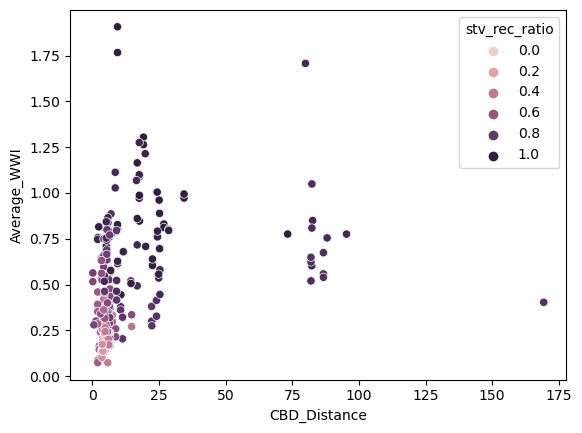

In [24]:
sns.scatterplot(data=count_sites[count_sites.Average_WWI < 10], x='CBD_Distance', y='Average_WWI', hue='stv_rec_ratio')

<AxesSubplot: xlabel='popden', ylabel='max_weekday_am_pm_value'>

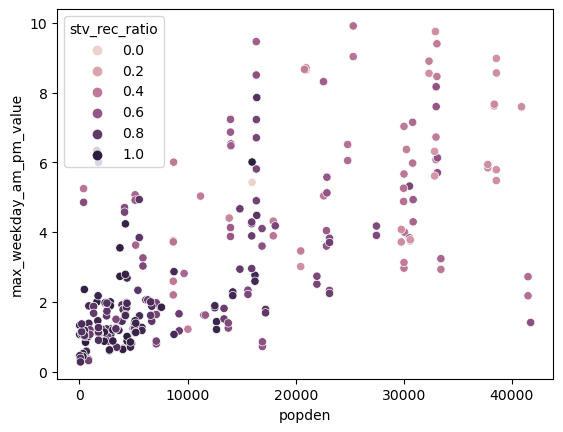

In [25]:
# weekday Pattern
sns.scatterplot(data=count_sites[count_sites.max_weekday_am_pm_value < 10], x='popden', y='max_weekday_am_pm_value', hue='stv_rec_ratio')

In [26]:
#sns.scatterplot(data=count_sites_f[count_sites_f.max_weekday_am_pm_value < 10], x='CBD_Distance', y='max_weekday_am_pm_value')

<AxesSubplot: xlabel='popden', ylabel='max_weekend_am_pm_Value'>

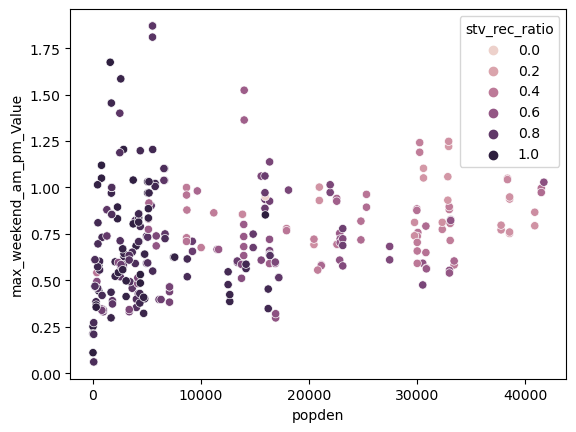

In [27]:
# weekend Pattern
sns.scatterplot(data=count_sites[count_sites.max_weekend_am_pm_Value< 3], x='popden', y='max_weekend_am_pm_Value', hue='stv_rec_ratio')

In [28]:
count_sites.shape

(595, 42)

In [29]:
count_sites = count_sites.reset_index(level=0)
count_sites = count_sites.reset_index(level=0)

In [30]:
count_sites.head()

,year,ID,index,Unnamed: 0.1,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,...,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD_Distance,popden
0,2016,671,0,0,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,...,308723101,215845474,NaN,NaN,NaN,NaN,NaN,POINT (-216265.861 -22230.259),5.149648,12677.958400
1,2017,671,1,1,2.893617,0.776723,0.743791,0.376689,1.974549,0.437975,...,308723101,215845474,NaN,NaN,NaN,NaN,NaN,POINT (-216265.861 -22230.259),5.149648,12677.958400
2,2018,671,2,2,1.352564,0.710009,0.863646,0.291176,2.966061,0.295405,...,308723101,215845474,4890.0,260.0,4630.0,0.053170,0.946830,POINT (-216265.861 -22230.259),5.149648,12677.958400
3,2019,671,3,3,1.435644,0.660785,0.820369,0.340759,2.407476,0.354620,...,308723101,215845474,4625.0,255.0,4370.0,0.055135,0.944865,POINT (-216265.861 -22230.259),5.149648,12677.958400
4,2016,1127,4,4,2.222222,0.257277,2.050485,0.584499,3.508108,0.736655,...,308779961,87297166,NaN,NaN,NaN,NaN,NaN,POINT (-212739.517 -21764.447),3.017938,41734.239831


# Develop the 10 fold CV Linear Regression model

In [31]:
def ln_model(X, Y):
    # Now we do 10fold cv without library
    num_folds = 10
    kfold = KFold(n_splits=10, shuffle=True, random_state=111)

    # Now we perform KFold:

    fold_num = 1
    lr_MAPE_train = []
    lr_MAPE_scores = []
    lr_RMSE_train = []
    lr_RMSE_scores = []
    lr_MAE_train = []
    lr_MAE_scores = []
    lr_R2_train = []
    lr_R2_scores = []
    test_pred = []
    # we split the entire dataframe:
    for train, test in kfold.split(X, Y):
        lr_CV_model = LinearRegression().fit(X[train], Y[train])
        train_predictions = lr_CV_model.predict(X[train])
        test_predictions = lr_CV_model.predict(X[test])
        predictions_df=dataset = pd.DataFrame(np.hstack((lr_CV_model.predict(X[test]), Y[test].reshape(-1, 1))))
        train_mape = mean_absolute_percentage_error(Y[train], train_predictions)
        lr_MAPE_train.append(train_mape)
        test_mape = mean_absolute_percentage_error(Y[test], test_predictions)
        lr_MAPE_scores.append(test_mape)
        train_rmse = math.sqrt(mean_squared_error(Y[train], train_predictions))
        lr_RMSE_train.append(train_rmse)
        test_rmse = math.sqrt(mean_squared_error(Y[test], test_predictions))
        lr_RMSE_scores.append(test_rmse)
        train_mae = mean_absolute_error(Y[train], train_predictions)
        lr_MAE_train.append(train_mae)
        test_mae = mean_absolute_error(Y[test], test_predictions)
        lr_MAE_scores.append(test_mae)
        train_r2 = r2_score(Y[train], train_predictions)
        lr_R2_train.append(train_r2)
        score_r2 = r2_score(Y[test], test_predictions)
        lr_R2_scores.append(score_r2)
        test_pred.append(predictions_df)
        appended_data=pd.concat(test_pred)
        print(
            f"------------------------------------------Fold {fold_num}------------------------------------------")
        print(f"\tTrain MAE: {train_mae}\tScore Loss: {test_mae}")
        print(f"\tTrain RMSE: {train_rmse}\tScore RMSE: {test_rmse}")
        print(f"\tTrain MAPE: {train_mape}\tScore MAPE: {test_mape}")
        print(f"\tTrain R2:   {train_r2}\tScore R2: {score_r2}")
        fold_num += 1

    print(f"\n\nOverall MAE: {np.mean(lr_MAE_scores)} +/- {np.std(lr_MAE_scores)}")
    print(f"Overall RMSE: {np.mean(lr_RMSE_scores)} +/- {np.std(lr_RMSE_scores)}")
    print(f"Overall MAPE: {np.mean(lr_MAPE_scores)} +/- {np.std(lr_MAPE_scores)}")
    print(f"Overall R2: {np.mean(lr_R2_scores)} +/- {np.std(lr_R2_scores)}\n\n")

    print("Delimited table for linear Regression 10 fold:")
    print("MAPE\tRMSE\tMAE\tR2")
    for i in range(0, 10):
        print("%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f" %
              (lr_MAPE_train[i], lr_MAPE_scores[i], lr_RMSE_train[i], lr_RMSE_scores[i], lr_MAE_train[i], lr_MAE_scores[i], lr_R2_train[i], lr_R2_scores[i]))
    print("%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t<===Averages" % (np.mean(lr_MAPE_train), np.mean(lr_MAPE_scores), np.mean(lr_RMSE_train),
          np.mean(lr_RMSE_scores), np.mean(lr_MAE_train), np.mean(lr_MAE_scores), np.mean(lr_R2_train), np.mean(lr_R2_scores)))
    print(f"lr_rf_fs_CV_model.coef_ ==\n{lr_CV_model.coef_}")
    print(f"\nlr_rf_fs_CV_model.intercept_ == {lr_CV_model.intercept_}")
    appended_data.to_csv('appended_data.csv',index=False)


In [32]:
count_sites['sqrt_popden']=np.sqrt(count_sites['popden'])
count_sites['sqrt_CBD_Distance']=np.sqrt(count_sites['CBD_Distance'])
count_sites['log_popden']=np.log(count_sites['popden'])
count_sites['log_CBD_Distance']=np.log(count_sites['CBD_Distance'])
count_sites['sqrt_stv_rec_ratio']=np.sqrt(count_sites['stv_rec_ratio'])
count_sites['sq_stv_rec_ratio']=np.power(count_sites['stv_rec_ratio'],2)
count_sites['sq_stv_com_ratio']=np.power(count_sites['stv_com_ratio'],2)
count_sites.head()

,year,ID,index,Unnamed: 0.1,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,...,geometry,CBD_Distance,popden,sqrt_popden,sqrt_CBD_Distance,log_popden,log_CBD_Distance,sqrt_stv_rec_ratio,sq_stv_rec_ratio,sq_stv_com_ratio
0,2016,671,0,0,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,...,POINT (-216265.861 -22230.259),5.149648,12677.958400,112.596440,2.269284,9.447620,1.638928,NaN,NaN,NaN
1,2017,671,1,1,2.893617,0.776723,0.743791,0.376689,1.974549,0.437975,...,POINT (-216265.861 -22230.259),5.149648,12677.958400,112.596440,2.269284,9.447620,1.638928,NaN,NaN,NaN
2,2018,671,2,2,1.352564,0.710009,0.863646,0.291176,2.966061,0.295405,...,POINT (-216265.861 -22230.259),5.149648,12677.958400,112.596440,2.269284,9.447620,1.638928,0.973052,0.896488,0.002827
3,2019,671,3,3,1.435644,0.660785,0.820369,0.340759,2.407476,0.354620,...,POINT (-216265.861 -22230.259),5.149648,12677.958400,112.596440,2.269284,9.447620,1.638928,0.972042,0.892770,0.003040
4,2016,1127,4,4,2.222222,0.257277,2.050485,0.584499,3.508108,0.736655,...,POINT (-212739.517 -21764.447),3.017938,41734.239831,204.289598,1.737221,10.639077,1.104574,NaN,NaN,NaN


Text(0.5, 0, 'ln(Popopulation Density)')

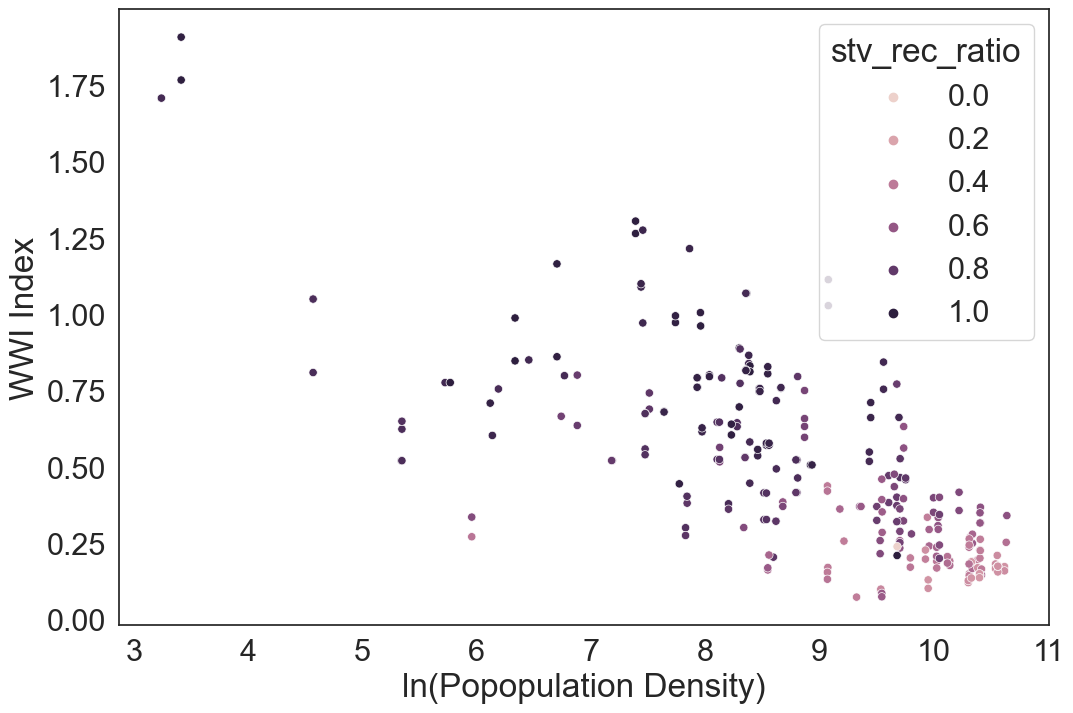

In [33]:

sns.set(rc={'figure.figsize':(12,8)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=2, color_codes=False, rc=None)
ax=sns.scatterplot(data=count_sites[count_sites.Average_WWI < 10], x='log_popden', y='Average_WWI', hue='stv_rec_ratio')
ax.set_ylabel('WWI Index' )
ax.set_xlabel('ln(Popopulation Density)')

Text(0.5, 0, 'Popopulation Density(/sq. mile)')

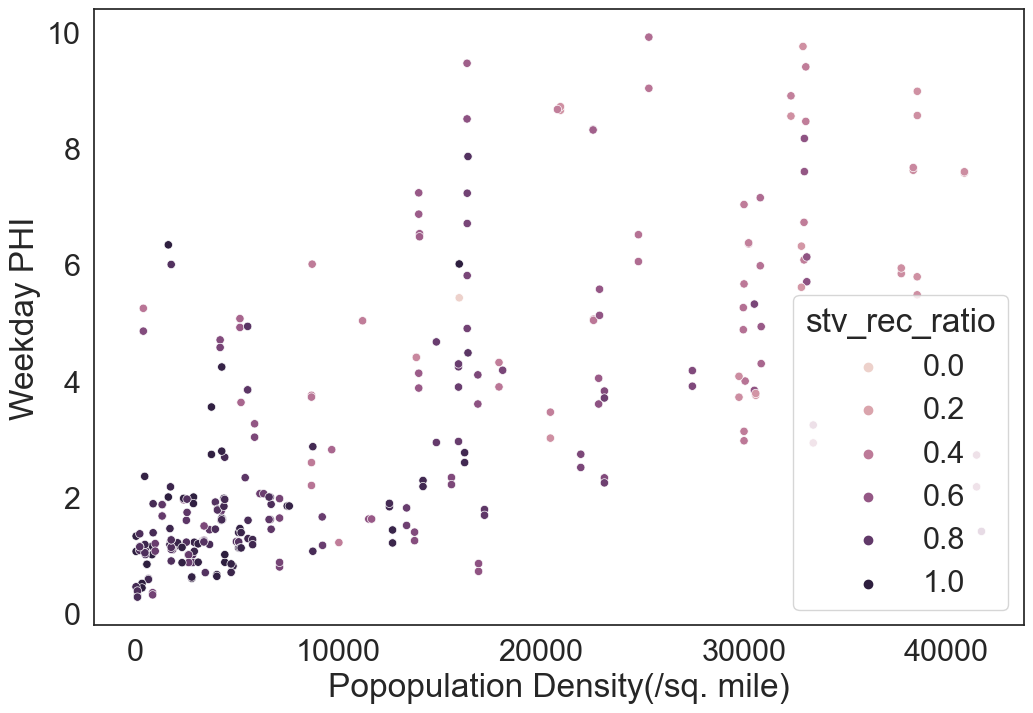

In [55]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=2, color_codes=False, rc=None)
ax=sns.scatterplot(data=count_sites[count_sites.max_weekday_am_pm_value < 10], x='popden', y='max_weekday_am_pm_value', hue='stv_rec_ratio')
ax.set_ylabel('Weekday PHI' )
ax.set_xlabel('Popopulation Density(/sq. mile)')

Text(0.5, 0, 'Sqrt(Population Density(/sq.mile))')

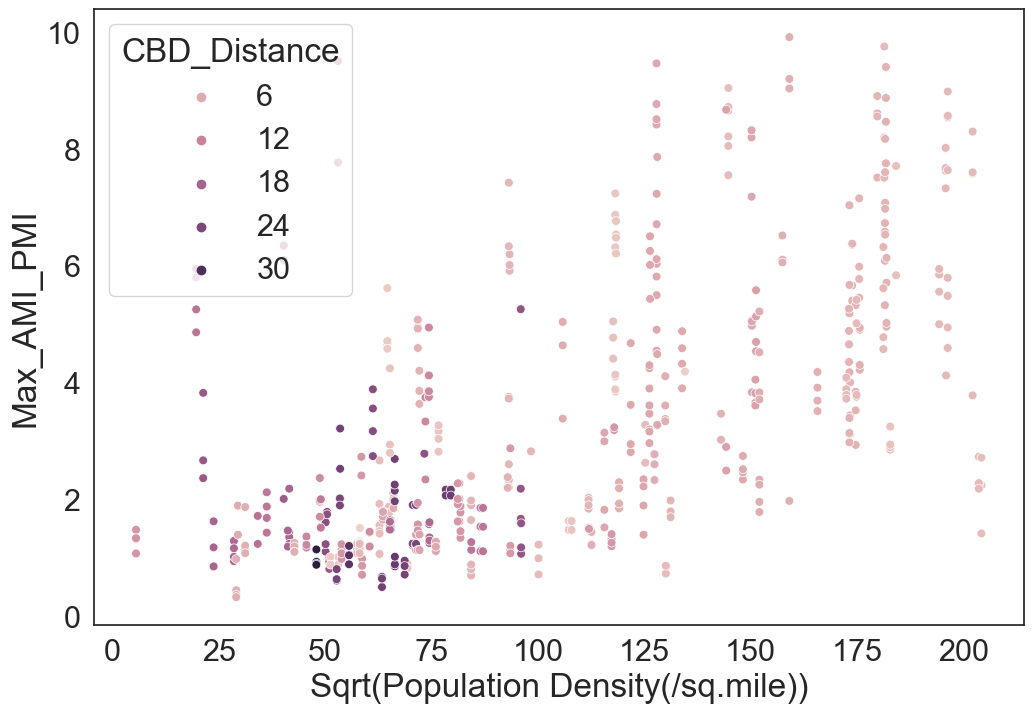

In [35]:
# weekday Pattern
count_sites_f=count_sites.loc[count_sites['CBD_Distance']<50]
#sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(12,8)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=2, color_codes=False, rc=None)
ax1=sns.scatterplot(data=count_sites_f[count_sites_f.max_weekday_am_pm_value < 10], x='sqrt_popden', y='max_weekday_am_pm_value', hue='CBD_Distance',s=40)
ax1.set_ylabel('Max_AMI_PMI' )
ax1.set_xlabel('Sqrt(Population Density(/sq.mile))')

Text(0.5, 0, 'Sqrt(Population Density(/sq.mile))')

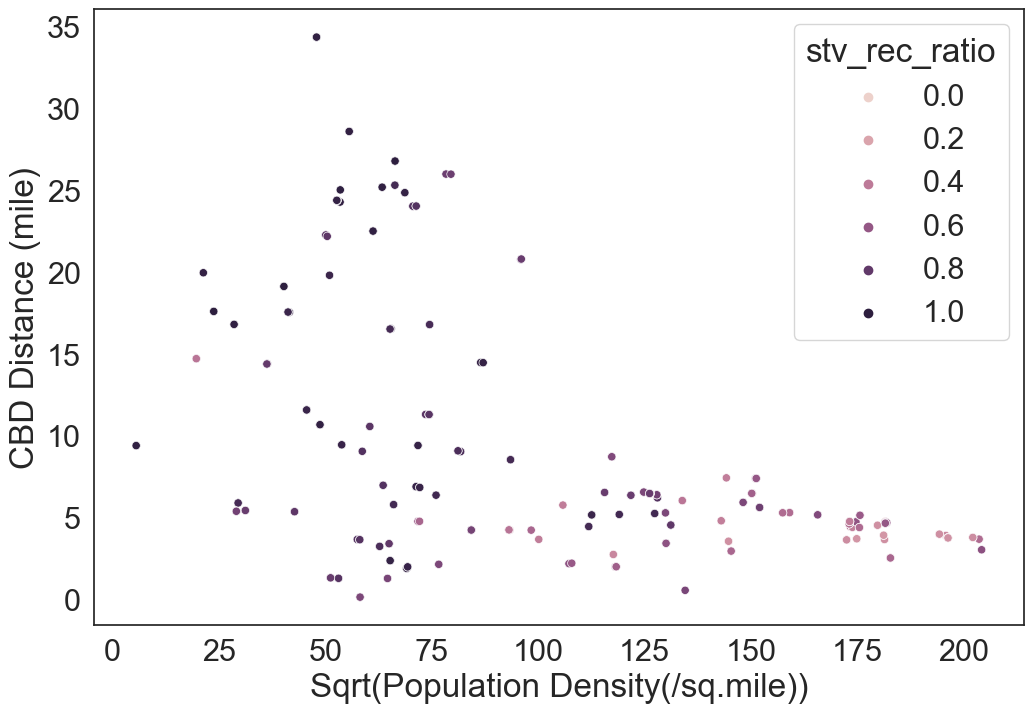

In [36]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=2, color_codes=False, rc=None)
ax1=sns.scatterplot(data=count_sites_f, x='sqrt_popden', y='CBD_Distance',hue='stv_rec_ratio')
ax1.set_ylabel('CBD Distance (mile)' )
ax1.set_xlabel('Sqrt(Population Density(/sq.mile))')

In [37]:
count_sites.columns

Index(['year', 'ID', 'index', 'Unnamed: 0.1', 'Max_WWI', 'Average_WWI',
       'Weekday_Aergage_AMI', 'Weekend_Aergage_AMI', 'Average AMI_wday_wend',
       'Max_weekend_AMI', 'Max_weekday_AMI', 'Daily_Max_AMI', 'Daily_Max_PMI',
       'Weekday_Aergage_PMI', 'Weekend_Aergage_PMI', 'Average PMI_wday_wend',
       'Max_weekday_PMI', 'Max_weekend_PMI', 'max_daily_am_pm',
       'max_daily_am/pm_value', 'max_weekend_am/pm', 'max_weekend_am_pm_Value',
       'max_weekday_am/pm', 'max_weekday_am_pm_value', 'seasonal_factor',
       'latitude', 'longitude', 'location', 'road', 'city', 'county', 'state',
       'country', 'Unnamed: 0', 'edgeUID', 'osmId', 'stv_total',
       'stv_com_total', 'stv_rec_total', 'stv_com_ratio', 'stv_rec_ratio',
       'geometry', 'CBD_Distance', 'popden', 'sqrt_popden',
       'sqrt_CBD_Distance', 'log_popden', 'log_CBD_Distance',
       'sqrt_stv_rec_ratio', 'sq_stv_rec_ratio', 'sq_stv_com_ratio'],
      dtype='object')

In [38]:
data=count_sites.loc[count_sites['Average_WWI'] < 1.5]
data1=data[(data.year==2018)|(data.year==2019)].reset_index()
X_data=data1[['log_popden','sq_stv_rec_ratio']]
Y_data=data1[['Average_WWI']]

In [39]:
scoring = {'mean_absolute_error': MAE_SCORER,
           'mean_squared_error': MSE_SCORER,
           'r2': R2_SCORER,
           'mean_absolute_percentage_error': MAPE_SCORER}

In [40]:
# # use the Sklearn library to run linear regression model
# lm = LinearRegression()
# # create a KFold object with 5 splits 
# folds = KFold(n_splits = 10, shuffle = True, random_state = 1)
# scores = cross_validate(lm, X_data, Y_data, cv=5,
#                         scoring=scoring, return_train_score=True)
# sorted(scores.keys())

In [41]:
# print(
#     f"Training MAPE:  {(-scores['train_mean_absolute_percentage_error']).mean()}\tTesting MAPE: {(-scores['test_mean_absolute_percentage_error']).mean()}")
# print(
#     f"Training RMSE: {(np.sqrt(-scores['train_mean_squared_error'])).mean()}\tTesting RMSE: {(np.sqrt(-scores['test_mean_squared_error'])).mean()}")
# print(
#     f"Training MAE:  {(-scores['train_mean_absolute_error']).mean()}\tTesting MAE: {(-scores['test_mean_absolute_error']).mean()}")
# print(
#     f"Training R2:   {(scores['train_r2']).mean()}\tTesting R2: {(scores['test_r2']).mean()}")



## Now Develop the Model WWI Vs log(Popden) and square root of Strava rectational ratio for weekday

In [42]:
X = np.asarray(X_data)
Y = np.asarray(Y_data)

In [43]:
ln_model(X, Y)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 0.11338625171037349	Score Loss: 0.11571160889897336
	Train RMSE: 0.15618756281699558	Score RMSE: 0.14807641058932577
	Train MAPE: 30.01398714994652	Score MAPE: 26.92610116979988
	Train R2:   0.6826085094253614	Score R2: 0.7524960269397133
------------------------------------------Fold 2------------------------------------------
	Train MAE: 0.11538207543569622	Score Loss: 0.10211999410354956
	Train RMSE: 0.1547176623980697	Score RMSE: 0.16415846954148336
	Train MAPE: 29.803726675409493	Score MAPE: 34.67912328251661
	Train R2:   0.7074256393578401	Score R2: -0.0971270124925101
------------------------------------------Fold 3------------------------------------------
	Train MAE: 0.11687565080102667	Score Loss: 0.08513033795954486
	Train RMSE: 0.1594497947087569	Score RMSE: 0.11388315391204805
	Train MAPE: 30.65053475006827	Score MAPE: 19.7344275013848
	Train R2:   0.6730020372561974	Scor

In [44]:
# plot the observation and Prediction

In [45]:
appended_data=pd.read_csv('appended_data.csv')
appended_data1=appended_data.rename(columns={'0':'Predicted WWI','1':'Observed WWI'})
appended_data1.head()

,Predicted WWI,Observed WWI
0,0.783325,0.961077
1,0.716442,1.068170
2,0.752201,0.888798
3,0.745071,0.746585
4,0.590654,0.380447


In [46]:
appended_data1['Observed WWI'].max()

1.30470404

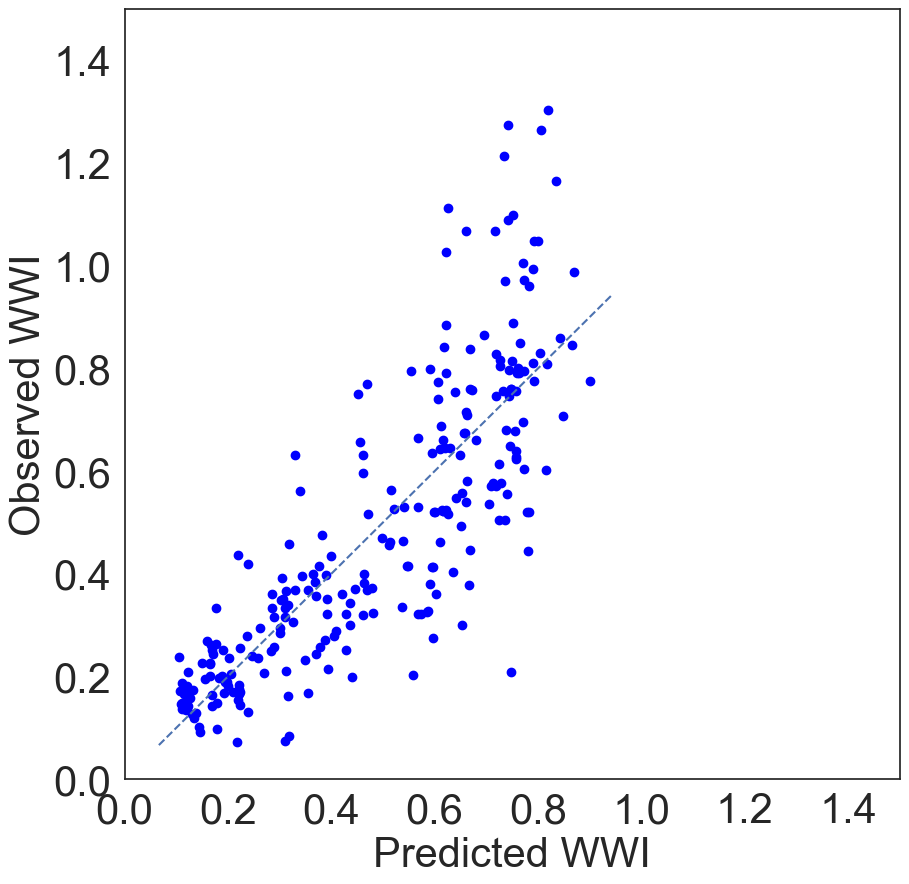

In [47]:
# Plot Observed Vs Predicted WWI
plt.figure(figsize=(10,10)) # Specify size of the chart
plt.scatter('Predicted WWI', 'Observed WWI', data=appended_data1, marker = 'o', c = 'blue')
abline(1, (0,0))
#plt.legend(('abline'), title='Legend',loc=1,prop={"size":18}, fancybox=True)
plt.xlabel('Predicted WWI', fontsize=30)
#prop={"size":18}, 
#fontsize=20,
plt.ylabel('Observed WWI', fontsize=30)
plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Now Develop the Model Max am_pm Vs Popden and Strava rectational ratio for weekday

In [48]:
data1['max_weekday_am_pm_value'] .describe()

count    256.000000
mean            inf
std             NaN
min        0.279107
25%        1.230438
50%        2.264405
75%        5.044463
max             inf
Name: max_weekday_am_pm_value, dtype: float64

In [49]:
data1.columns

Index(['level_0', 'year', 'ID', 'index', 'Unnamed: 0.1', 'Max_WWI',
       'Average_WWI', 'Weekday_Aergage_AMI', 'Weekend_Aergage_AMI',
       'Average AMI_wday_wend', 'Max_weekend_AMI', 'Max_weekday_AMI',
       'Daily_Max_AMI', 'Daily_Max_PMI', 'Weekday_Aergage_PMI',
       'Weekend_Aergage_PMI', 'Average PMI_wday_wend', 'Max_weekday_PMI',
       'Max_weekend_PMI', 'max_daily_am_pm', 'max_daily_am/pm_value',
       'max_weekend_am/pm', 'max_weekend_am_pm_Value', 'max_weekday_am/pm',
       'max_weekday_am_pm_value', 'seasonal_factor', 'latitude', 'longitude',
       'location', 'road', 'city', 'county', 'state', 'country', 'Unnamed: 0',
       'edgeUID', 'osmId', 'stv_total', 'stv_com_total', 'stv_rec_total',
       'stv_com_ratio', 'stv_rec_ratio', 'geometry', 'CBD_Distance', 'popden',
       'sqrt_popden', 'sqrt_CBD_Distance', 'log_popden', 'log_CBD_Distance',
       'sqrt_stv_rec_ratio', 'sq_stv_rec_ratio', 'sq_stv_com_ratio'],
      dtype='object')

In [50]:
data2=data1.loc[data1['max_weekday_am_pm_value'] < 10]
#data2=data2.loc[data2['CBD_Distance']<50]
X1=np.asarray(data2[['popden','sq_stv_rec_ratio']])
Y1=np.asarray(data2[['max_weekday_am_pm_value']])
ln_model(X1, Y1)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 1.0665572139749322	Score Loss: 1.812957625151218
	Train RMSE: 1.5210119739998913	Score RMSE: 2.402491703660735
	Train MAPE: 49.89496202382711	Score MAPE: 44.79424077022433
	Train R2:   0.5670898488059912	Score R2: 0.3687636856037826
------------------------------------------Fold 2------------------------------------------
	Train MAE: 1.168086597602296	Score Loss: 1.0759790599168355
	Train RMSE: 1.645091087567259	Score RMSE: 1.396044338876718
	Train MAPE: 54.36467301474828	Score MAPE: 35.68871947344952
	Train R2:   0.5367102635808536	Score R2: 0.7036382156001288
------------------------------------------Fold 3------------------------------------------
	Train MAE: 1.1841776690388648	Score Loss: 1.0269267758407492
	Train RMSE: 1.657519074854506	Score RMSE: 1.2630681858282302
	Train MAPE: 54.88221492684725	Score MAPE: 44.894615872985845
	Train R2:   0.5549732807095346	Score R2: 0.65934034

In [51]:
appended_data=pd.read_csv('appended_data.csv')
appended_data2=appended_data.rename(columns={'0':'Predicted Max AMIPMI','1':'Observed Max AMIPMI'})
appended_data2.tail()

,Predicted Max AMIPMI,Observed Max AMIPMI
246,5.855526,5.258065
247,4.115126,2.244019
248,4.115126,3.704000
249,3.418197,4.289377
250,2.027473,2.000000


In [52]:
appended_data2['Predicted Max AMIPMI'].describe()

count    251.000000
mean       3.251205
std        1.844348
min        0.728937
25%        1.605192
50%        2.853673
75%        4.797394
max        7.056146
Name: Predicted Max AMIPMI, dtype: float64

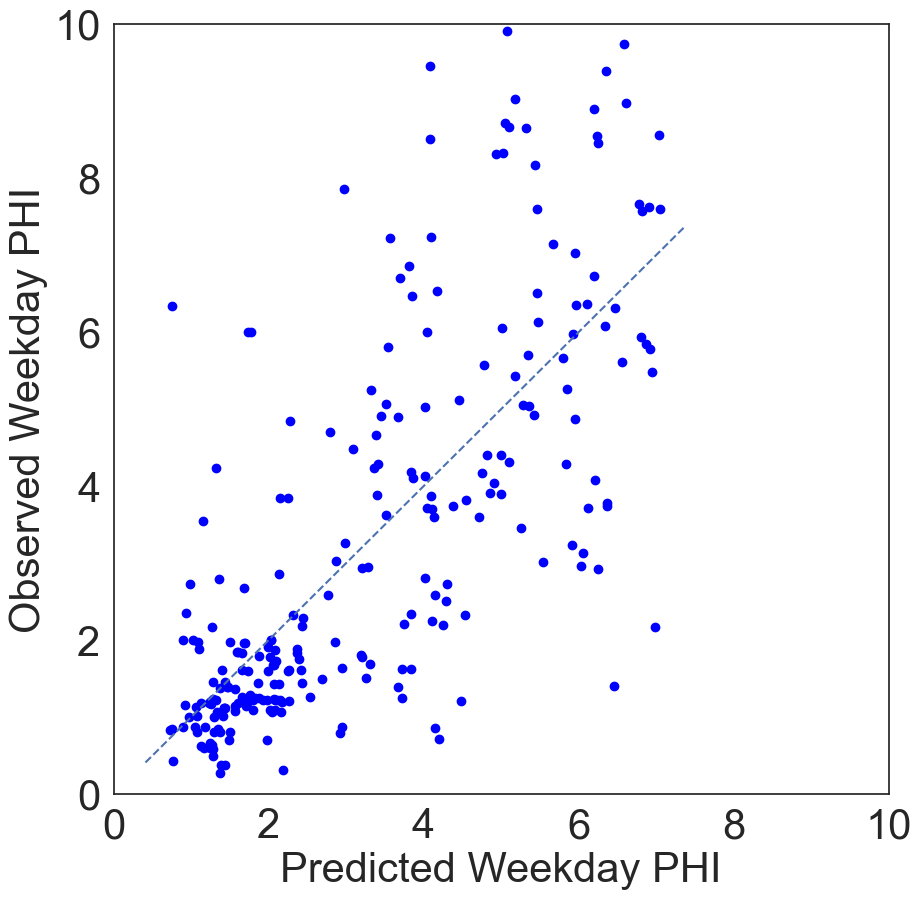

In [54]:
# Plot Observed Vs Predicted WWI
plt.figure(figsize=(10,10)) # Specify size of the chart
plt.scatter('Predicted Max AMIPMI', 'Observed Max AMIPMI', data=appended_data2, marker = 'o', c = 'blue')
abline(1, (0,0))
#plt.legend(('abline'), title='Legend',loc=1,prop={"size":18}, fancybox=True)
plt.xlabel('Predicted Weekday PHI', fontsize=30)
#prop={"size":18}, 
#fontsize=20,
plt.ylabel('Observed Weekday PHI', fontsize=30)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

In [606]:
# use this model if Strava data is not available
X11=np.asarray(data2[['sqrt_popden','log_CBD_Distance']])
Y11=np.asarray(data2[['max_weekday_am_pm_value']])
ln_model(X11, Y11)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 1.33192629470215	Score Loss: 0.8576928775358219
	Train RMSE: 1.7724423802422289	Score RMSE: 1.2432084835719548
	Train MAPE: 58.523925908817674	Score MAPE: 49.881856508961455
	Train R2:   0.4892683268666991	Score R2: 0.6880811157080704
------------------------------------------Fold 2------------------------------------------
	Train MAE: 1.2867349601518858	Score Loss: 1.1790313554760414
	Train RMSE: 1.7492934565214093	Score RMSE: 1.5127844152057122
	Train MAPE: 57.783499062093355	Score MAPE: 42.8258875399316
	Train R2:   0.49928442162366493	Score R2: 0.5841712686312184
------------------------------------------Fold 3------------------------------------------
	Train MAE: 1.269476261960153	Score Loss: 1.4048565511361386
	Train RMSE: 1.7131874588876637	Score RMSE: 1.8366682191419677
	Train MAPE: 57.63463750661766	Score MAPE: 55.51808533556003
	Train R2:   0.5212440297634597	Score R2: 0.374

In [607]:
appended_data1=pd.read_csv('appended_data.csv')
appended_data3=appended_data1.rename(columns={'0':'Predicted Max AMIPMI','1':'Observed Max AMIPMI'})
appended_data3.tail()

,Predicted Max AMIPMI,Observed Max AMIPMI
242,5.704593,5.258065
243,4.987446,3.823077
244,4.364419,4.314775
245,5.709419,3.130068
246,2.565880,2.000000


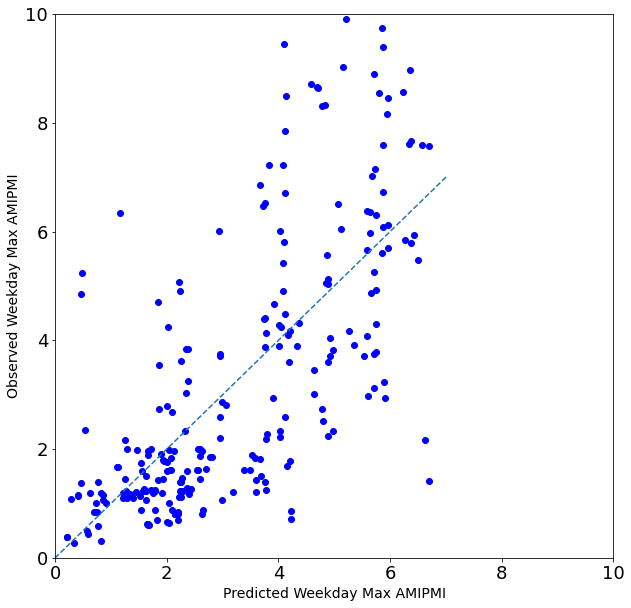

In [608]:
# Plot Observed Vs Predicted WWI
plt.figure(figsize=(10,10)) # Specify size of the chart
plt.scatter('Predicted Max AMIPMI', 'Observed Max AMIPMI', data=appended_data3, marker = 'o', c = 'blue')
abline(1, (0,0))
#plt.legend(('abline'), title='Legend',loc=1,prop={"size":18}, fancybox=True)
plt.xlabel('Predicted Weekday Max AMIPMI', fontsize=14)
#prop={"size":18}, 
#fontsize=20,
plt.ylabel('Observed Weekday Max AMIPMI', fontsize=14)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [663]:
# use this model if Strava data is not available for weekend classification
X111=np.asarray(data2[['sqrt_popden','log_CBD_Distance']])
Y111=np.asarray(data2[['stv_rec_ratio']])
ln_model(X111, Y111)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 0.11719590249951872	Score Loss: 0.11827019746910462
	Train RMSE: 0.15063451829623983	Score RMSE: 0.1352337429400272
	Train MAPE: inf	Score MAPE: 17.92078503026933
	Train R2:   0.5841207038971759	Score R2: 0.630563104204661
------------------------------------------Fold 2------------------------------------------
	Train MAE: 0.11913643325309027	Score Loss: 0.10314672433392806
	Train RMSE: 0.15112281755235532	Score RMSE: 0.13027798037918514
	Train MAPE: inf	Score MAPE: 17.214842674332022
	Train R2:   0.583411399540057	Score R2: 0.6611003287569827
------------------------------------------Fold 3------------------------------------------
	Train MAE: 0.11526304031224019	Score Loss: 0.1384995566211787
	Train RMSE: 0.14619088441910236	Score RMSE: 0.17344915504968947
	Train MAPE: inf	Score MAPE: 27.02276896183254
	Train R2:   0.6082231608032667	Score R2: 0.4240312193338899
-------------------

In [667]:
appended_data2=pd.read_csv('appended_data.csv')
appended_data4=appended_data2.rename(columns={'0':'Predicted Strava Recreational Ratio','1':'Observed Strava Recreational Ratio'})
appended_data4.tail()

,Predicted Strava Recreational Ratio,Observed Strava Recreational Ratio
242,0.481517,0.452801
243,0.550097,0.671007
244,0.606916,0.381867
245,0.481964,0.391760
246,0.776498,0.875421


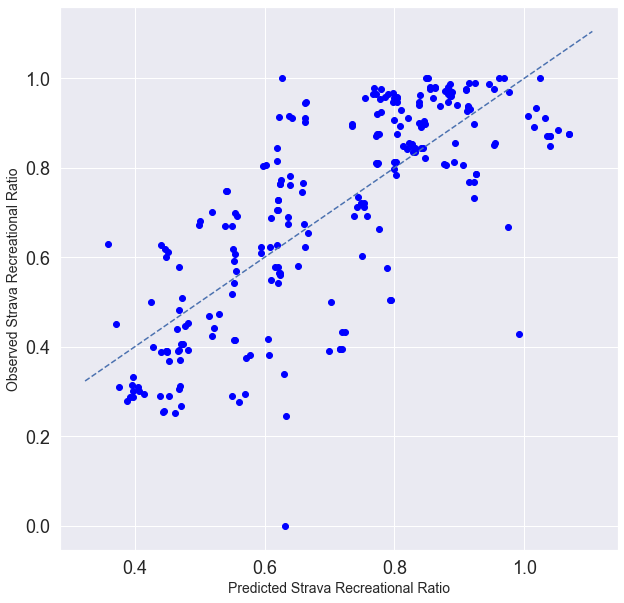

In [670]:
# Plot Observed Vs Predicted WWI
plt.figure(figsize=(10,10)) # Specify size of the chart
plt.scatter('Predicted Strava Recreational Ratio', 'Observed Strava Recreational Ratio', data=appended_data4, marker = 'o', c = 'blue')
abline(1, (0,0))
#plt.legend(('abline'), title='Legend',loc=1,prop={"size":18}, fancybox=True)
plt.xlabel('Predicted Strava Recreational Ratio', fontsize=14)
#prop={"size":18}, 
#fontsize=20,
plt.ylabel('Observed Strava Recreational Ratio', fontsize=14)
#plt.xlim(0,2)
#plt.ylim(0,2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Try Negative Binomial Model

In [556]:
data2.columns

Index(['level_0', 'year', 'ID', 'index', 'Unnamed: 0.1', 'Max_WWI',
       'Average_WWI', 'Weekday_Aergage_AMI', 'Weekend_Aergage_AMI',
       'Average AMI_wday_wend', 'Max_weekend_AMI', 'Max_weekday_AMI',
       'Daily_Max_AMI', 'Daily_Max_PMI', 'Weekday_Aergage_PMI',
       'Weekend_Aergage_PMI', 'Average PMI_wday_wend', 'Max_weekday_PMI',
       'Max_weekend_PMI', 'max_daily_am_pm', 'max_daily_am_pm_value',
       'max_weekend_am_pm', 'max_weekend_am_pm_Value', 'max_weekday_am_pm',
       'max_weekday_am_pm_value', 'seasonal_factor', 'latitude', 'longitude',
       'location', 'road', 'city', 'county', 'state', 'country', 'Unnamed: 0',
       'edgeUID', 'osmId', 'stv_total', 'stv_com_total', 'stv_rec_total',
       'stv_com_ratio', 'stv_rec_ratio', 'geometry', 'CBD_Distance', 'popden',
       'sqrt_popden', 'sqrt_CBD_Distance', 'log_popden', 'log_CBD_Distance',
       'sqrt_stv_rec_ratio', 'sq_stv_rec_ratio', 'sq_stv_com_ratio'],
      dtype='object')

In [567]:
NB_df=data2
formula_str="max_weekday_am_pm_value ~  log_popden+sq_stv_rec_ratio+sqrt_CBD_Distance"
start = time.time()
num_folds = 10
kfold = KFold(n_splits=10, shuffle = True, random_state = 1)

# Now we perform KFold:

fold_num = 1
NB_MAPE_train = []
NB_MAPE_scores = []
NB_RMSE_train = []
NB_RMSE_scores = []
NB_MAE_train = []
NB_MAE_scores = []
NB_R2_train = []
NB_R2_scores = []

# we split the entire dataframe:
for train, test in kfold.split(NB_df):
    NB_CV_model = smf.glm(formula_str, data=NB_df.iloc[train],family=sm.families.NegativeBinomial()).fit(cov_type='HC1', use_t=True)
    train_predictions = NB_CV_model.predict(NB_df.iloc[train])
    test_predictions = NB_CV_model.predict(NB_df.iloc[test])
    train_mae = mean_absolute_error(NB_df.iloc[train]['max_weekday_am_pm_value'], train_predictions)
    NB_MAE_train.append(train_mae)
    test_mae = mean_absolute_error(NB_df.iloc[test]['max_weekday_am_pm_value'], test_predictions)
#    print(NB_df.iloc[test]['aadb1'], test_predictions)
    NB_MAE_scores.append(test_mae)
    train_rmse = math.sqrt(mean_squared_error(NB_df.iloc[train]['max_weekday_am_pm_value'], train_predictions))
    NB_RMSE_train.append(train_rmse)
    test_rmse = math.sqrt(mean_squared_error(NB_df.iloc[test]['max_weekday_am_pm_value'], test_predictions))
    NB_RMSE_scores.append(test_rmse)
    train_mape = mean_absolute_percentage_error(NB_df.iloc[train]['max_weekday_am_pm_value'], train_predictions)
    NB_MAPE_train.append(train_mape)
    test_mape = mean_absolute_percentage_error(NB_df.iloc[test]['max_weekday_am_pm_value'], test_predictions)
    NB_MAPE_scores.append(test_mape)
    train_r2 = r2_score(NB_df.iloc[train]['max_weekday_am_pm_value'], train_predictions)
    NB_R2_train.append(train_r2)
    score_r2 = r2_score(NB_df.iloc[test]['max_weekday_am_pm_value'], test_predictions)
    NB_R2_scores.append(score_r2)
    print(f"------------------------------------------Fold {fold_num}------------------------------------------")
    print(f"\tTrain MAE: {train_mae}\tScore Loss: {test_mae}")
    print(f"\tTrain RMSE: {train_rmse}\tScore RMSE: {test_rmse}")
    print(f"\tTrain MAPE: {train_mape}\tScore MAPE: {test_mape}")
    print(f"\tTrain R2:   {train_r2}\tScore R2: {score_r2}")
    fold_num += 1

print(f"\n\nOverall MAE: {np.mean(NB_MAE_scores)} +/- {np.std(NB_MAE_scores)}")
print(f"Overall RMSE: {np.mean(NB_RMSE_scores)} +/- {np.std(NB_RMSE_scores)}")
print(f"Overall MAPE: {np.mean(NB_MAPE_scores)} +/- {np.std(NB_MAPE_scores)}")
print(f"Overall R2: {np.mean(NB_R2_scores)} +/- {np.std(NB_R2_scores)}\n\n")

print("Delimited table for negative binomial 10 fold:")
print("MAPE\tRMSE\tMAE\tR2")
for i in range(0,10):
    print("%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f" % (NB_MAPE_train[i], NB_MAPE_scores[i], NB_RMSE_train[i], NB_RMSE_scores[i], NB_MAE_train[i], NB_MAE_scores[i], NB_R2_train[i], NB_R2_scores[i]))
print("%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t<===Averages" % (np.mean(NB_MAPE_train), np.mean(NB_MAPE_scores), np.mean(NB_RMSE_train), np.mean(NB_RMSE_scores), np.mean(NB_MAE_train), np.mean(NB_MAE_scores), np.mean(NB_R2_train), np.mean(NB_R2_scores)))
end = time.time()
print("Tune Fit Time:", end - start)
NB_CV_model.summary()

------------------------------------------Fold 1------------------------------------------
	Train MAE: 1.181874530953919	Score Loss: 1.5372526705062224
	Train RMSE: 1.6176974305065102	Score RMSE: 2.0778419105865673
	Train MAPE: 47.11138121324452	Score MAPE: 73.44209986444112
	Train R2:   0.5862921740901156	Score R2: -0.21755716918318235
------------------------------------------Fold 2------------------------------------------
	Train MAE: 1.2036085871842648	Score Loss: 1.4816093397063688
	Train RMSE: 1.633467295450925	Score RMSE: 1.842634186801493
	Train MAPE: 47.44953523589234	Score MAPE: 94.38544971796105
	Train R2:   0.5365631458993679	Score R2: 0.6092072239490733
------------------------------------------Fold 3------------------------------------------
	Train MAE: 1.2255209570904408	Score Loss: 1.0574442070302608
	Train RMSE: 1.6552909944598253	Score RMSE: 1.6039485009408663
	Train MAPE: 51.50122458476743	Score MAPE: 34.66701425787769
	Train R2:   0.5620113640397828	Score R2: 0.3623

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     max_weekday_am_pm_value   No. Observations:                  210
Model:                                 GLM   Df Residuals:                      206
Model Family:             NegativeBinomial   Df Model:                            3
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -464.88
Date:                     Wed, 28 Dec 2022   Deviance:                       36.383
Time:                             21:50:28   Pearson chi2:                     42.9
No. Iterations:                          6   Pseudo R-squ. (CS):             0.2138
Covariance Type:                       HC1                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1569      0.590      0.266      0.791      -1.007       1.321
log_popden            0.1705      0.054      3.162      0.002       0.064       0.277
sq_stv_rec_ratio     -1.4971      0.191     -7.840      0.000      -1.874      -1.121
sqrt_CBD_Distance     0.0561      0.047      1.199      0.232      -0.036       0.148
=====================================================================================
"""

# Now Develop the Model Max am_pm Vs Popden and Strava rectational ratio for weekend

In [120]:
data3=data1.loc[data1['max_weekend_am_pm_Value'] < 10]
X2=np.asarray(data3[['popden','stv_rec_ratio']])
Y2=np.asarray(data3[['max_weekend_am_pm_Value']])

In [79]:
ln_model(X2, Y2)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 0.25100490262171554	Score Loss: 0.2645989171131574
	Train RMSE: 0.49413389607073144	Score RMSE: 0.3613683657915816
	Train MAPE: 44.10036152007425	Score MAPE: 40.32441890104547
	Train R2:   0.0021442525780550614	Score R2: 0.0023411518292876243
------------------------------------------Fold 2------------------------------------------
	Train MAE: 0.25367555996136115	Score Loss: 0.22871855083982312
	Train RMSE: 0.4981131943289842	Score RMSE: 0.31005370127480575
	Train MAPE: 44.298976832927714	Score MAPE: 33.59829206453057
	Train R2:   0.002515043175172149	Score R2: -0.007177961424053025
------------------------------------------Fold 3------------------------------------------
	Train MAE: 0.25789255212486517	Score Loss: 0.2196944663832006
	Train RMSE: 0.5011970252539157	Score RMSE: 0.26436647022395143
	Train MAPE: 44.735176196606865	Score MAPE: 40.07105005765851
	Train R2:   0.001094009687

In [80]:
appended_data=pd.read_csv('appended_data.csv')
appended_data2=appended_data.rename(columns={'0':'Predicted Max AMIPMI','1':'Observed Max AMIPMI'})
appended_data2.head()

,Predicted Max AMIPMI,Observed Max AMIPMI
0,0.750492,1.674200
1,0.755392,0.969743
2,0.767149,0.902439
3,0.763882,0.354236
4,0.809439,1.189707


In [81]:
appended_data2['Observed Max AMIPMI'].max()

6.0

# End of the Idices Prediction